In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO
from main.components.preprocessing_methods import get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear


pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
df = pd.read_csv(dataset_file_path)
df.sample(5)

,"PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro",IGF-1 ng/ml (N: 100-311),proBNP,"AMH (ng/ml) *7,14=pmol/l",weight,height (cm),BMI,systolic BP (ciśnienie skurczowe),diastolic BP (ciśnienie rozskurczowe),Hypertension,Waist Circumference (WC),WC>88,Hip Circumference (HC),WHR (Waist/Hip ratio),"WHR>0,85 (WHO)","WHR>0,8 (NIDDK)",WHTR (Waist/Height Ratio),"WHTR>0,5","overweight/obesity 0-normal/low, 1-overweight, 2-obesity","irregular cycles (0-nie, 1-tak)","ovulation (0-brak, 1-obecna)","PCO ovary morfology in USG (0-brak, 1--obecna)","stromal hypertrophy in ovary (0-brak, 1-obecny)",acne,hirsutism,FG score (Ferriman-Gallway score - stopień androgenizacji),hyperandrogenism,hypothyroidism,Volume of the thyroid Right Lobe,Volume of the thyroid Left Lobe,thyroid volume,"nodules 0-lack, 1-RL, 2-LL, 3-both",chronic thyroiditis,Vole of the Right Ovary,Volume of the Left Ovary,ovaries volume - total,follicules >12,hyperlipidemia,elevated LDL and TG,WBC x10^3/ul,neutrophil x10^3/ul,lymphocytes x10^3/ul,monocytes x10^3/ul,eosinocytes x10^3/ul,basophils x10^3/ul,% neutrophil,% lymphocytes,% monocytes,%eosinocytes,%basophils,RBC x10^6ul,Hemoglobin [g/dl],hematocrit [%],HTC/Hb,MCV fl,MCH pg,MCHC g/dl,RDW-CV %,NRBC x10^3/ul,PLT x10^3/ul,PDW fl,MPV fl,P-LCR %,PLT/WBC,MPV/PLT,PLR,limf/mono,NLR (stosunek neutrofili do limfocytów),L/WCC (leukocyty do całkowitej liczby krwinek białych),eos/leukocyty,sodium mmol/l,potassium mmol/l,calcium mg/dl,phosphorus mg/dl,creatinine mg/dl,CRP mg/l,ALT U/l,AST U/l,Bilirubin mg/dl,CHOL mg/dl,CHOL mmol/l,CHOL>200,HDL mg/dl,HDL mmol/l,HDL<50,LDL mg/dl,LDL mmol/l,LDL>135,TG,TG mmol/l,TG>150,Atherogenic index (AI) (LDL-C/HDL-C),coronary risk index (CRI) (TG/HDL-C),VAI - Visceral adiposity index,BAI - Body adiposity index,LAP INDEX - Lipid accumulation product index,TyG Index - Trigliceride-glucose index,AIP -Atherogenic index of plasma,UIBC ug/dl,ferrum ug/dl,TIBC,TSAT,ferritin ng/ml,glucose 0 mg/dl,glucose 120 mg/dl,insulin 0 uU/ml,Insulin 120 uU/ml,HOMA,Matsuda,"QUICKI (N<0,357)",Impaired Fasting Glucose,Impaired Glucose Tolerance,TSH mIU/L,FT3 pmol/l,FT4 pmol/l,Anty-TPO IU/ml,Anty-TG IU/ml,FSH mlU/ml,LH,LH/FSH,prolactin,DHEA-S ug/dl,testosterone nmol/l,T (ng/ml),T/SHBG,E(pg/ml)/T(ng/ml)/,Parathormone pg/ml,cortisol nmol/l 8:00,cortisol nmol/l 18:00,Estradiol pg/ml,SHBG nmol/l,FTI (free testosterone index),ACTH pg/ml,HbA1c %,vitamin 25-OH D ng/ml,Androstendione ng/ml,17-OH-progesterone ng/ml,Dihydrotestosterone pg/ml (N<368),Testosterone/DHT,T/A (testosterone/androstendione),month of birth,quarter of the year,age
618,1,422.0,39.64,6.413165,96.0,165.0,35.261708,119.0,68.0,0.0,103.0,1.0,109.0,0.944954,1.0,1.0,0.624242,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0,1.0,0.0,8.20800,5.67000,13.87800,0.0,0.0,13.872,12.41,26.282,1.0,0.0,0.0,10.56,5.51,4.01,0.66,0.34,0.04,25.1,38.0,6.3,3.2,0.4,4.46,12.6,37.0,2.936508,83.0,28.3,34.1,12.6,0.0,259.0,10.3,9.4,20.4,24.526515,0.036293,64.588529,6.075758,1.374065,0.379735,0.032197,142.0,4.17,7.71,4.17,0.61,1.2,22.0,15.0,0.23,147.0,3.80142,0.0,36.0,0.93096,1.0,89.4,2.311884,0.0,108.0,1.21932,0.0,2.483333,3.000000,2.452444,48.060606,54.86940,4.568239,0.477121,260.0,88.0,348.0,25.0,84.0,86.0,99.0,17.95,59.94,3.811605,3.93,0.313621,0.0,0.0,3.31,6.10,13.40,16.0,10.0,2.8,5.3,1.892857,269.0,597.0,2.6,0.749280,0.145251,164.157691,43.15,379.0,144.0,123.0,17.9,14.35,34.91,5.1,17.0,4.81,5.25,677.0,0.003840,0.540541,11.0,4.0,18.0
864,2,248.0,NaN,7.430000,44.5,156.0,18.285667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.88600,2.24400,5.13000,0.0,1.0,6.280,3.84,10.120,0.0,0.0,0.0,5.79,2.34,2.57,0.42,0.41,0.05,40.3,44.4,7.3,7.1,0.9,4.07,11.5,35.9,3.121739,88.2,28.3,32.0,13.2,0.0,260.0,13.9,11.1,34.3,44.905009,0.042692,101.167315,6.119048,0.910506,0.443869,0.070812,141.0,4.39,10.16,4.22,0.86,0.3,11.0,19.0,0.57,214.0,5.53404,1.0,89.0,2.30154,0.0,109.0,2.818740,0.0,81.0,0.91449,0.0,1.224719,0.910112,NaN,NaN,NaN,4.400584,-0.040905,215.0,84.0,299.0,28.0,52.0

In [7]:
df_igf_cleaned = df.dropna(subset=[IGF])

X_igf, y_igf = df_igf_cleaned.drop(columns=[IGF]), df_igf_cleaned[IGF]
X_train_igf, X_val_igf, y_train_igf, y_val_igf = train_test_split(X_igf, y_igf, test_size=0.2, random_state=42)

## Models exploration

In [8]:
models = [
        DecisionTreeRegressor(max_depth=7, random_state=42),
        Lasso(),
        Ridge(),
        RandomForestRegressor(),
        ]

#  TODO: maybe add DropHighMissingColumns

continuous_preprocessings = {
    'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
    'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
    'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
}

categorical_preprocessings = {
    # 'custom_ohe_no_imputing': Pipeline([('one_hot_encoder', CustomOneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True))]),
    'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
    'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
}


scores_df = explore_all_variations_of_preprocessing(X_train_igf, y_train_igf, IGF, models, continuous_preprocessings, categorical_preprocessings)

1/48 DecisionTreeRegressor(max_depth=7, random_state=42) PT_iterative_basic original_ohe_no_imputing [-71.42146125 -86.52416007 -77.06086085 -77.6960309  -65.22213995
 -87.3326502  -58.35277079 -83.03002733 -70.28025084 -77.09305163
 -76.95734161 -82.85818702 -77.50083197 -83.84546095 -72.13991723] 76.48767617250061
2/48 Lasso() PT_iterative_basic original_ohe_no_imputing [-62.52149945 -63.48342818 -65.85754222 -60.98206036 -65.31404261
 -66.81839919 -56.15943523 -59.29320659 -58.85662724 -56.92910083
 -60.70163767 -59.81683253 -65.05162081 -67.81602926 -57.19351234] 61.78633163531215
3/48 Ridge() PT_iterative_basic original_ohe_no_imputing [-73.49539945 -70.89918795 -74.99311633 -74.08460496 -92.25250736
 -75.27847961 -71.95463176 -67.30198561 -77.03922909 -64.10302008
 -63.02234735 -72.16719286 -77.2903278  -79.02278674 -65.2463899 ] 73.21008045694856
4/48 RandomForestRegressor() PT_iterative_basic original_ohe_no_imputing [-60.39617647 -61.23796961 -60.18129802 -64.40479901 -58.3295

,continuous_preprocessing,categorical_pteprocessing,model,MAE
0,PT_iterative_basic,original_ohe_no_imputing,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.487676
1,PT_iterative_basic,original_ohe_no_imputing,Lasso(),61.786332
2,PT_iterative_basic,original_ohe_no_imputing,Ridge(),73.210080
3,PT_iterative_basic,original_ohe_no_imputing,RandomForestRegressor(),59.844091
4,PT_iterative_basic,original_ohe_+_impute_knn,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.877851
5,PT_iterative_basic,original_ohe_+_impute_knn,Lasso(),61.622067
6,PT_iterative_basic,original_ohe_+_impute_knn,Ridge(),72.232321
7,PT_iterative_basic,original_ohe_+_impute_knn,RandomForestRegressor(),59.914922
8,PT_iterative_basic,original_ohe_+_impute_rf,"DecisionTreeRegressor(max_depth=7, random_state=42)",76.664880
9,PT_iterative_basic,original_ohe_+_impute_rf,Lasso(),61.508069


In [12]:
scores_df = _

In [18]:
scores_df.groupby(by=['continuous_preprocessing', 'categorical_pteprocessing'])['MAE'].mean()

continuous_preprocessing  categorical_pteprocessing
PT_KNN                    original_ohe_+_impute_knn    68.565143
                          original_ohe_+_impute_rf     68.069553
                          original_ohe_no_imputing     68.015265
PT_iterative_basic        original_ohe_+_impute_knn    67.661790
                          original_ohe_+_impute_rf     67.407574
                          original_ohe_no_imputing     67.832045
RS_KNN                    original_ohe_+_impute_knn    67.762641
                          original_ohe_+_impute_rf     67.329345
                          original_ohe_no_imputing     67.658700
RS_iterative_basic        original_ohe_+_impute_knn    67.396318
                          original_ohe_+_impute_rf     67.399054
                          original_ohe_no_imputing     68.233051
Name: MAE, dtype: float64

In [19]:
scores_df.groupby(by=['continuous_preprocessing'])['MAE'].mean()

continuous_preprocessing
PT_KNN                68.216654
PT_iterative_basic    67.633803
RS_KNN                67.583562
RS_iterative_basic    67.676141
Name: MAE, dtype: float64

In [20]:
scores_df.groupby(by=['categorical_pteprocessing'])['MAE'].mean()

categorical_pteprocessing
original_ohe_+_impute_knn    67.846473
original_ohe_+_impute_rf     67.551382
original_ohe_no_imputing     67.934765
Name: MAE, dtype: float64

Best combo: RS_KNN + original_ohe_+_impute_rf 

In [23]:
continuous_preprocessor = Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))])
categorical_preprocessor = Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

### Hyperparameter tuning

### Lasso

Fitting 15 folds for each of 4 candidates, totalling 60 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


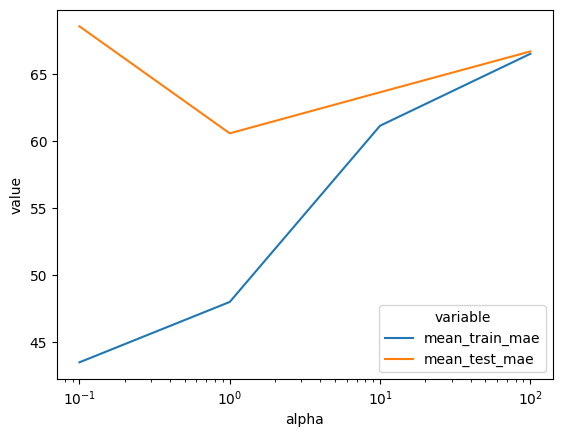

,alpha,mean_train_mae,mean_test_mae
0,0.1,43.472818,68.598900
1,1,47.988321,60.597173
2,10,61.164738,63.667794
3,100,66.544382,66.721878


In [27]:
param_grid_lasso = {
    'model__alpha': [0.1, 1, 10, 100],
}

vit_d_lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Lasso(), continuous_preprocessor, categorical_preprocessor, param_grid_lasso, main_parameter='alpha')
vit_d_lasso_model_hyperparam_tuning_df

### Ridge

In [ ]:
param_grid_ridge = {
    "model__alpha": [0.1, 1, 10, 100, 1000, 10000],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Ridge(), continuous_preprocessor, categorical_preprocessor, param_grid_ridge, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

### RandomForest

In [30]:
param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [20, None],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [5, 10],
    # 'bootstrap': [True, False],
}


vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, RandomForestRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
vit_d_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 32 candidates, totalling 480 fits


ValueError: Invalid parameter 'max_depth' for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                                  ('imputer',
                                                                   KNNImputer(n_neighbors=9))]),
                                                  ['proBNP',
                                                   'AMH (ng/ml) *7,14=pmol/l',
                                                   'weight', 'height (cm)',
                                                   'BMI',
                                                   'systolic BP (ciśnienie '
                                                   'skurczowe)',
                                                   'diastolic BP (ciśnienie '
                                                   'rozskurczowe)',
                                                   'Waist Circumference (WC)',
                                                   'Hip Circumference (HC)',
                                                   'WHR (Waist/H...
                                                   'ovary (0-brak, 1-obecny)',
                                                   'acne', 'hirsutism',
                                                   'hyperandrogenism',
                                                   'hypothyroidism',
                                                   'nodules 0-lack, 1-RL,  '
                                                   '2-LL, 3-both',
                                                   'chronic thyroiditis',
                                                   'follicules >12',
                                                   'hyperlipidemia',
                                                   'elevated LDL and TG',
                                                   'CHOL>200', 'HDL<50',
                                                   'LDL>135', 'TG>150',
                                                   'Impaired Fasting Glucose ',
                                                   'Impaired Glucose Tolerance',
                                                   'month of birth',
                                                   'quarter of the year'])])),
                ('model', RandomForestRegressor())]). Valid parameters are: ['memory', 'steps', 'verbose'].

### DecisionTreeRegressor

In [29]:
param_grid_tree = {
    "model__criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    "model__max_depth": [2, 4, 6],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 30],
    "model__min_samples_leaf": [10, 20],
    }

vit_d_tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, DecisionTreeRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_tree)
vit_d_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 15 folds for each of 2 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
import nest_asyncio
nest_asyncio.apply()

def compare_random_states(X_train, y_train, model, target_attribute):
    random_options = range(1,100)

    tune_df = pd.DataFrame(index=random_options, columns=['cv_mae'])

    for random_o in tqdm(random_options):
        attributes_to_scale = get_continuous_attributes_except(target_attribute)
        imputer = Imputer(IterativeImputer(max_iter=20, tol=0.01, initial_strategy='median'),
                    KNNImputer(n_neighbors=1),
                    attributes_to_scale,
                    CATEGORICAL_ATTRIBUTES)

        one_hot_encoder = CustomOneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True)
        
        model.set_params(random_state=random_o)
        
        pipeline = Pipeline([('imputer', imputer), ('one_hot_encoder', one_hot_encoder), ('model', model)])

        cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

        tune_df.at[random_o,'cv_mae'] = cv_score.mean()

    return tune_df


model = DecisionTreeRegressor(criterion="absolute_error", max_depth=2, min_samples_leaf=20, min_samples_split=15, splitter='random')

tuned_df = compare_random_states(X_train_vit_d, y_train_vit_d, model, vit_d)

In [81]:
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

,cv_mae
41,-8.855443
11,-8.900574
95,-8.918115
75,-8.941773
72,-8.945843


# Model selection for IGF

In [134]:
df_igf_cleaned = df.dropna(subset=[igf])

X_igf, y_igf = df_igf_cleaned.drop(columns=[igf]), df_igf_cleaned[igf]
X_train_igf, X_val_igf, y_train_igf, y_val_igf = train_test_split(X_igf, y_igf, test_size=0.2, random_state=42)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.220e+03, tolerance: 3.157e+02
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END model__alpha=0.1;, score=(train=-46.417, test=-62.031) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.693e+03, tolerance: 2.820e+02
  model = cd_fast.enet_coordinate_descent(


[CV 2/5] END model__alpha=0.1;, score=(train=-42.570, test=-74.737) total time= 4.4min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.491e+04, tolerance: 2.909e+02
  model = cd_fast.enet_coordinate_descent(


[CV 3/5] END model__alpha=0.1;, score=(train=-44.097, test=-72.657) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.037e+05, tolerance: 3.088e+02
  model = cd_fast.enet_coordinate_descent(


[CV 4/5] END model__alpha=0.1;, score=(train=-47.273, test=-59.808) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+04, tolerance: 2.826e+02
  model = cd_fast.enet_coordinate_descent(


[CV 5/5] END model__alpha=0.1;, score=(train=-45.772, test=-73.797) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1;, score=(train=-51.221, test=-54.685) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1;, score=(train=-48.154, test=-64.722) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1;, score=(train=-48.945, test=-68.194) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1;, score=(train=-52.337, test=-51.786) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1;, score=(train=-49.531, test=-69.544) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10;, score=(train=-61.049, test=-54.346) total time= 2.1min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10;, score=(train=-58.640, test=-66.689) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10;, score=(train=-59.399, test=-62.982) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10;, score=(train=-62.061, test=-55.678) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10;, score=(train=-60.048, test=-65.793) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=100;, score=(train=-68.552, test=-58.855) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=100;, score=(train=-65.246, test=-71.237) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=100;, score=(train=-66.086, test=-68.205) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=100;, score=(train=-67.576, test=-63.582) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=100;, score=(train=-65.344, test=-71.460) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


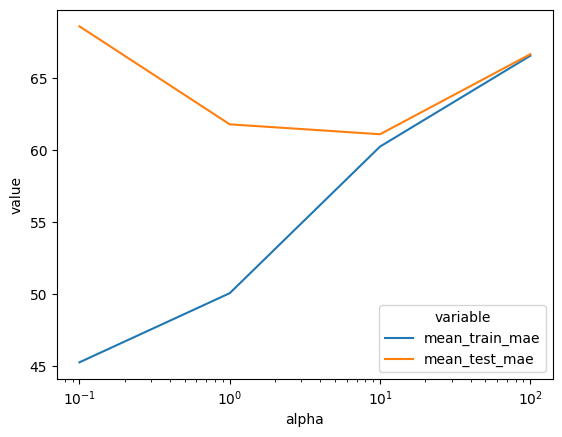

,alpha,mean_train_mae,mean_test_mae
0,0.1,45.226062,68.606081
1,1,50.037617,61.786273
2,10,60.239375,61.097537
3,100,66.560503,66.667712


In [31]:
lasso_model = Lasso()

lasso_param_grid = {
    "model__alpha": [0.1, 1, 10, 100],
    }

igf_lasso_model_hyperparam_tuning_df = hyperparameter_tuning(igf, lasso_model, lasso_param_grid)
igf_lasso_model_hyperparam_tuning_df

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=0.1;, score=(train=-45.196, test=-67.386) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=0.1;, score=(train=-40.884, test=-103.000) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=0.1;, score=(train=-43.106, test=-79.350) total time= 1.7min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=0.1;, score=(train=-45.183, test=-65.246) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=0.1;, score=(train=-44.462, test=-72.048) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1;, score=(train=-45.961, test=-63.678) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1;, score=(train=-41.929, test=-81.152) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1;, score=(train=-43.763, test=-73.146) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1;, score=(train=-46.908, test=-61.399) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1;, score=(train=-45.301, test=-73.072) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10;, score=(train=-47.697, test=-59.050) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10;, score=(train=-44.380, test=-70.762) total time= 2.0min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10;, score=(train=-45.532, test=-68.992) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10;, score=(train=-49.291, test=-55.068) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10;, score=(train=-46.560, test=-70.881) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=100;, score=(train=-51.972, test=-53.866) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=100;, score=(train=-49.398, test=-63.884) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=100;, score=(train=-49.417, test=-67.426) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=100;, score=(train=-53.021, test=-51.441) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=100;, score=(train=-49.787, test=-67.300) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=1000;, score=(train=-59.257, test=-53.142) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=1000;, score=(train=-56.182, test=-65.292) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=1000;, score=(train=-56.303, test=-66.368) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=1000;, score=(train=-59.296, test=-54.374) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=1000;, score=(train=-56.226, test=-66.901) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 1/5] END model__alpha=10000;, score=(train=-66.102, test=-57.288) total time= 1.9min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 2/5] END model__alpha=10000;, score=(train=-62.809, test=-69.722) total time= 1.8min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 3/5] END model__alpha=10000;, score=(train=-63.563, test=-66.689) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 4/5] END model__alpha=10000;, score=(train=-65.596, test=-61.099) total time= 1.5min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[CV 5/5] END model__alpha=10000;, score=(train=-63.006, test=-69.856) total time= 1.6min


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


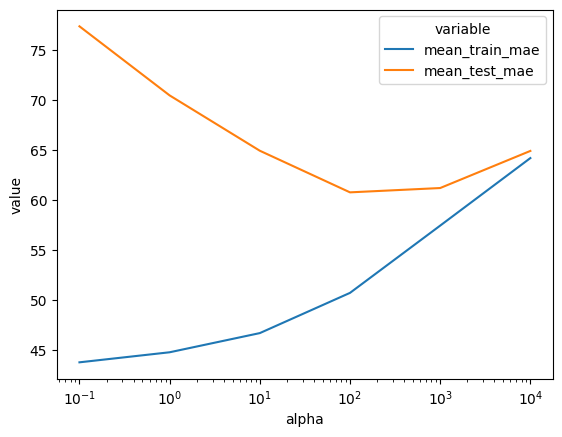

,alpha,mean_train_mae,mean_test_mae
0,0.1,43.766195,77.405932
1,1,44.772158,70.489377
2,10,46.691952,64.950500
3,100,50.719224,60.783290
4,1000,57.452877,61.215583
5,10000,64.215082,64.930906


In [32]:
ridge_model = Ridge()

ridge_param_grid = {
    "model__alpha": [0.1, 1, 10, 100, 1000, 10000],
    }

igf_ridge_model_hyperparam_tuning_df = hyperparameter_tuning(igf, ridge_model, ridge_param_grid)
igf_ridge_model_hyperparam_tuning_df

In [135]:
tree_model = DecisionTreeRegressor()

tree_param_grid = {
    "model__criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    "model__max_depth": [2, 4, 6],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 30],
    "model__min_samples_leaf": [10, 20],
    }

igf_tree_model_hyperparam_tuning_df = hyperparameter_tuning_tree(X_train_igf, y_train_igf, igf, tree_model, tree_param_grid)
igf_tree_model_hyperparam_tuning_df.sort_values(by='mean_test_mae')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,params,mean_train_mae,mean_test_mae
14,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",61.853568,60.912317
22,"{'model__criterion': 'absolute_error', 'model__max_depth': 6, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",54.603692,62.177809
19,"{'model__criterion': 'absolute_error', 'model__max_depth': 4, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",56.591204,62.184186
42,"{'model__criterion': 'friedman_mse', 'model__max_depth': 4, 'model__min_samples_leaf': 20, 'model__min_samples_split': 15, 'model__splitter': 'random'}",58.623109,62.273657
27,"{'model__criterion': 'poisson', 'model__max_depth': 2, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__splitter': 'random'}",61.750187,62.373929
13,"{'model__criterion': 'absolute_error', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",61.575854,62.475936
24,"{'model__criterion': 'poisson', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__splitter': 'random'}",62.411440,62.590617
25,"{'model__criterion': 'poisson', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",61.713405,62.671962
1,"{'model__criterion': 'squared_error', 'model__max_depth': 2, 'model__min_samples_leaf': 10, 'model__min_samples_split': 30, 'model__splitter': 'random'}",61.142885,62.994537
4,"{'model__criterion': 'squared_error', 'model__max_depth': 4, 'model__min_samples_leaf': 10, 'model__min_samples_split': 15, 'model__splitter': 'random'}",57.393490,63.266706


In [ ]:
model = DecisionTreeRegressor(criterion="squared_error", max_depth=2, min_samples_leaf=20, min_samples_split=15, splitter='random')

compare_random_states(X_train_igf, y_train_igf, model, igf)

## Best models - IGF

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


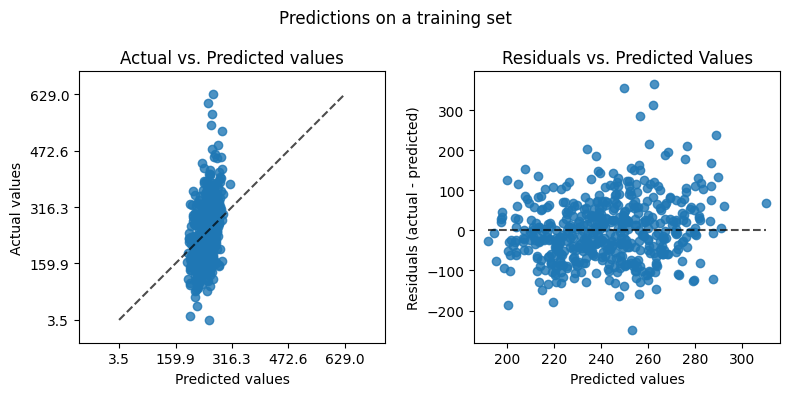

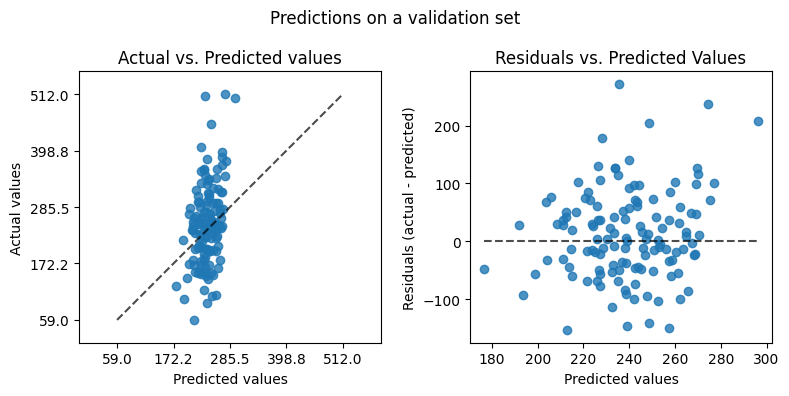

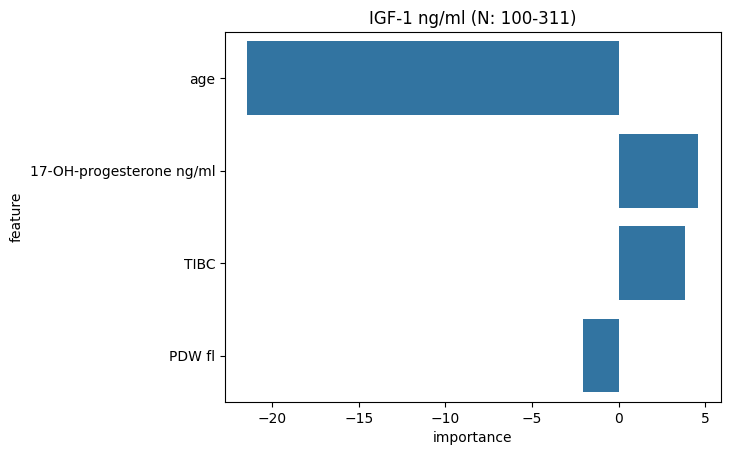

,model,test_set,mse,mae,rmse,r2
0,Lasso(alpha=10),training,6175.747,60.451,78.586,0.154
1,Lasso(alpha=10),validation,6209.989,60.946,78.803,0.103


In [39]:
lasso_model = Lasso(alpha=10)

igf_model_scores_df, feature_importnces_lasso = train_model(lasso_model, igf, get_feature_importance_lasso)
igf_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


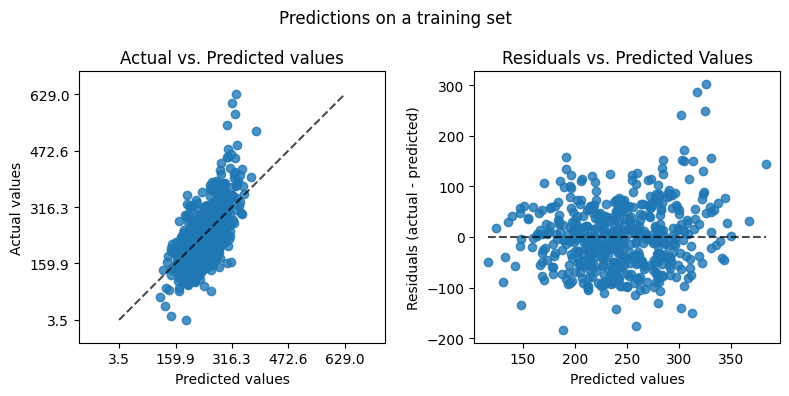

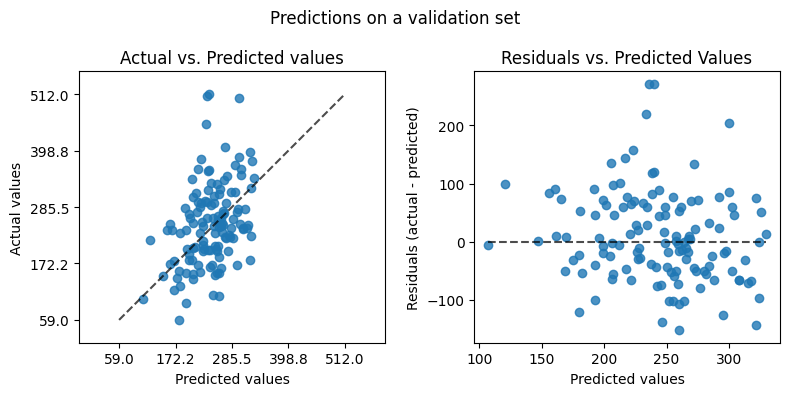

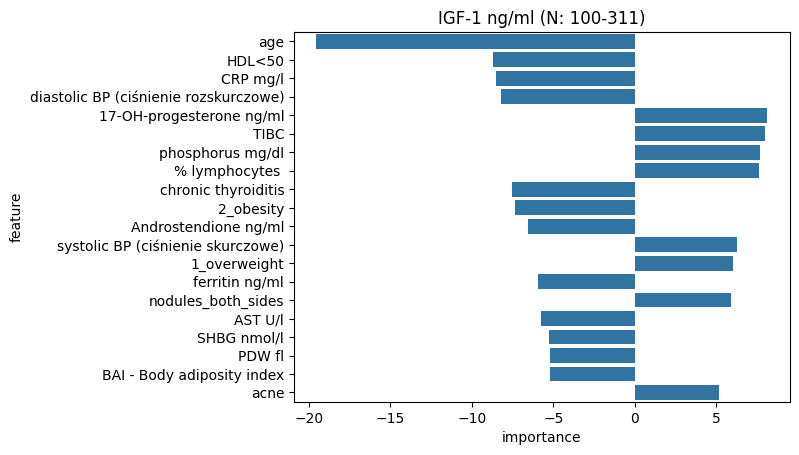

,model,test_set,mse,mae,rmse,r2
0,Ridge(alpha=100),training,4307.767,51.337,65.634,0.410
1,Ridge(alpha=100),validation,6183.909,60.553,78.638,0.107


In [138]:
ridge_model = Ridge(alpha=100)

igf_model_scores_df, feature_importnces_ridge = train_model(ridge_model, igf, get_feature_importance_lasso)
igf_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


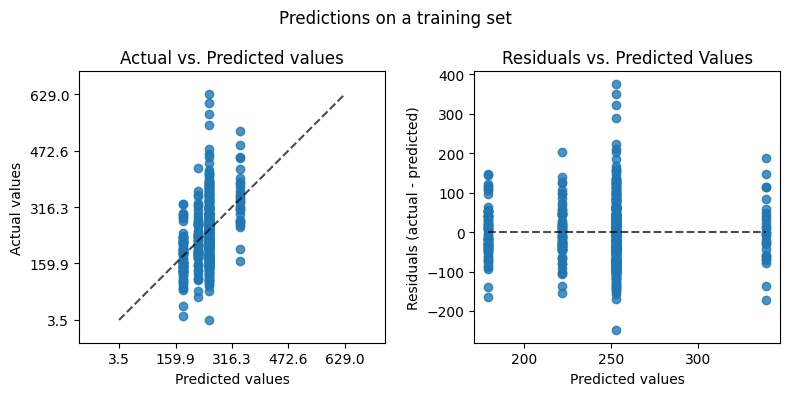

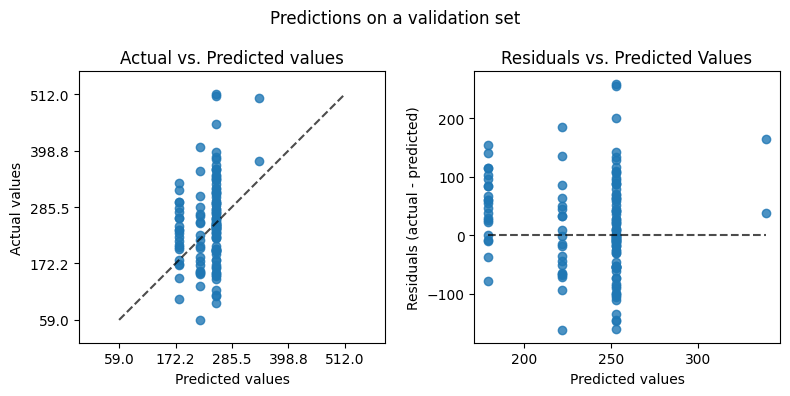

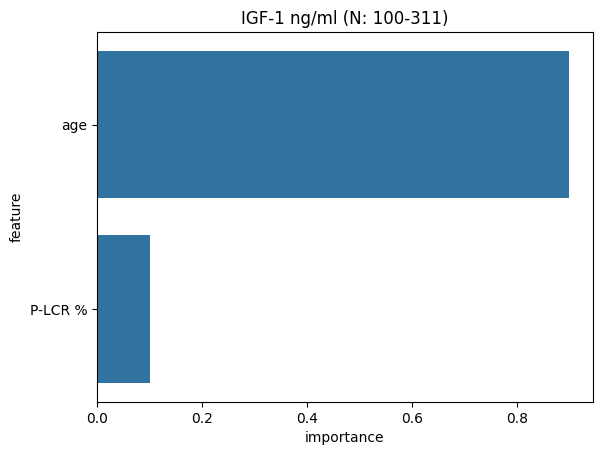

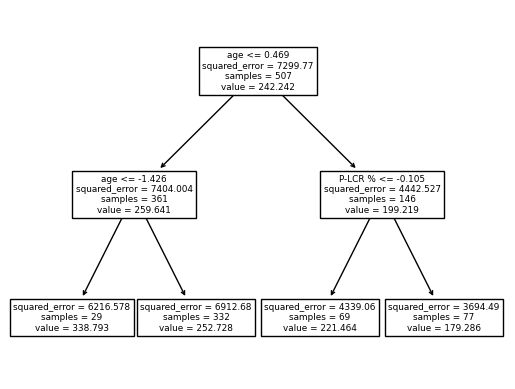

,model,test_set,mse,mae,rmse,r2
0,"DecisionTreeRegressor(max_depth=2, min_samples_leaf=20, min_samples_split=15,\n random_state=42)",training,6033.849,59.457,77.678,0.173
1,"DecisionTreeRegressor(max_depth=2, min_samples_leaf=20, min_samples_split=15,\n random_state=42)",validation,6768.068,64.014,82.268,0.023


In [137]:
tree_model = DecisionTreeRegressor(criterion='squared_error', max_depth=2, min_samples_leaf=20, min_samples_split=15, random_state=42)

igf_model_scores_df, feature_importnces_tree = train_model(tree_model, igf, get_feature_importance_tree)
igf_model_scores_df